<a href="https://colab.research.google.com/github/hcbt/stock_predict/blob/master/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize everything

In [ ]:
!pip install yfinance

In [ ]:
import math
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import plotly.express as px

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import yfinance as yf

yf.pdr_override()

ticker = "aapl"
start_date = "2000-1-1"
end_date = "2020-02-20"
 
data = pdr.get_data_yahoo(ticker, start = start_date, end = end_date)
data.to_csv("df.csv")
df = pd.read_csv("df.csv")

[*********************100%***********************]  1 of 1 completed


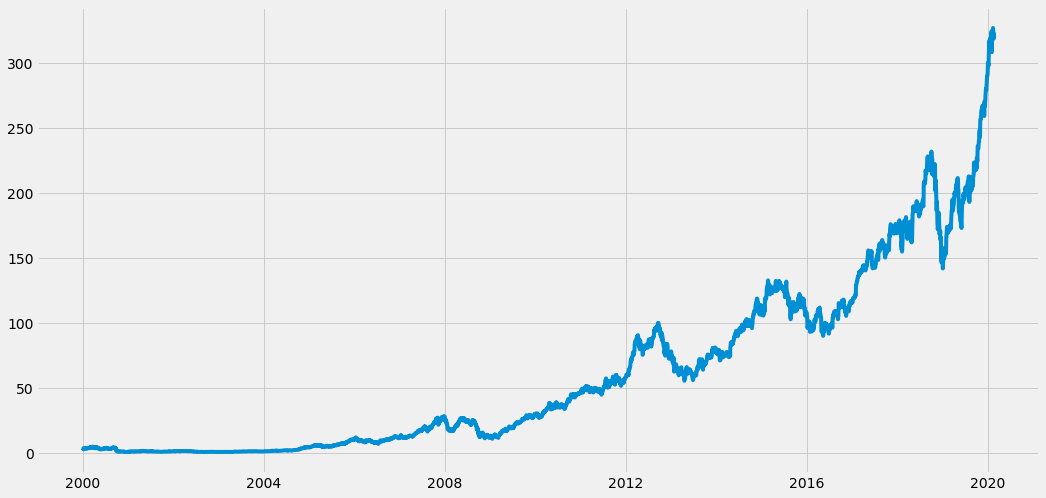

In [ ]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [ ]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Close'])
for i in range(0,len(data)):
    new_dataset["Close"][i]=data["Close"][i]

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values
train_data=final_dataset[0:5031,:]
valid_data=final_dataset[5031:,:]
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)
x_train_data,y_train_data=[],[]
for i in range(33,len(train_data)):
    x_train_data.append(scaled_data[i-33:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [ ]:
model=Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-33:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.fit(x_train_data,y_train_data,epochs=1,batch_size=1)

4998/4998 [==============================] - 73s 15ms/step - loss: 3.5209e-04


In [ ]:
X_test=[]
for i in range(33,inputs_data.shape[0]):
    X_test.append(inputs_data[i-33:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [ ]:
model.save("model.h5")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



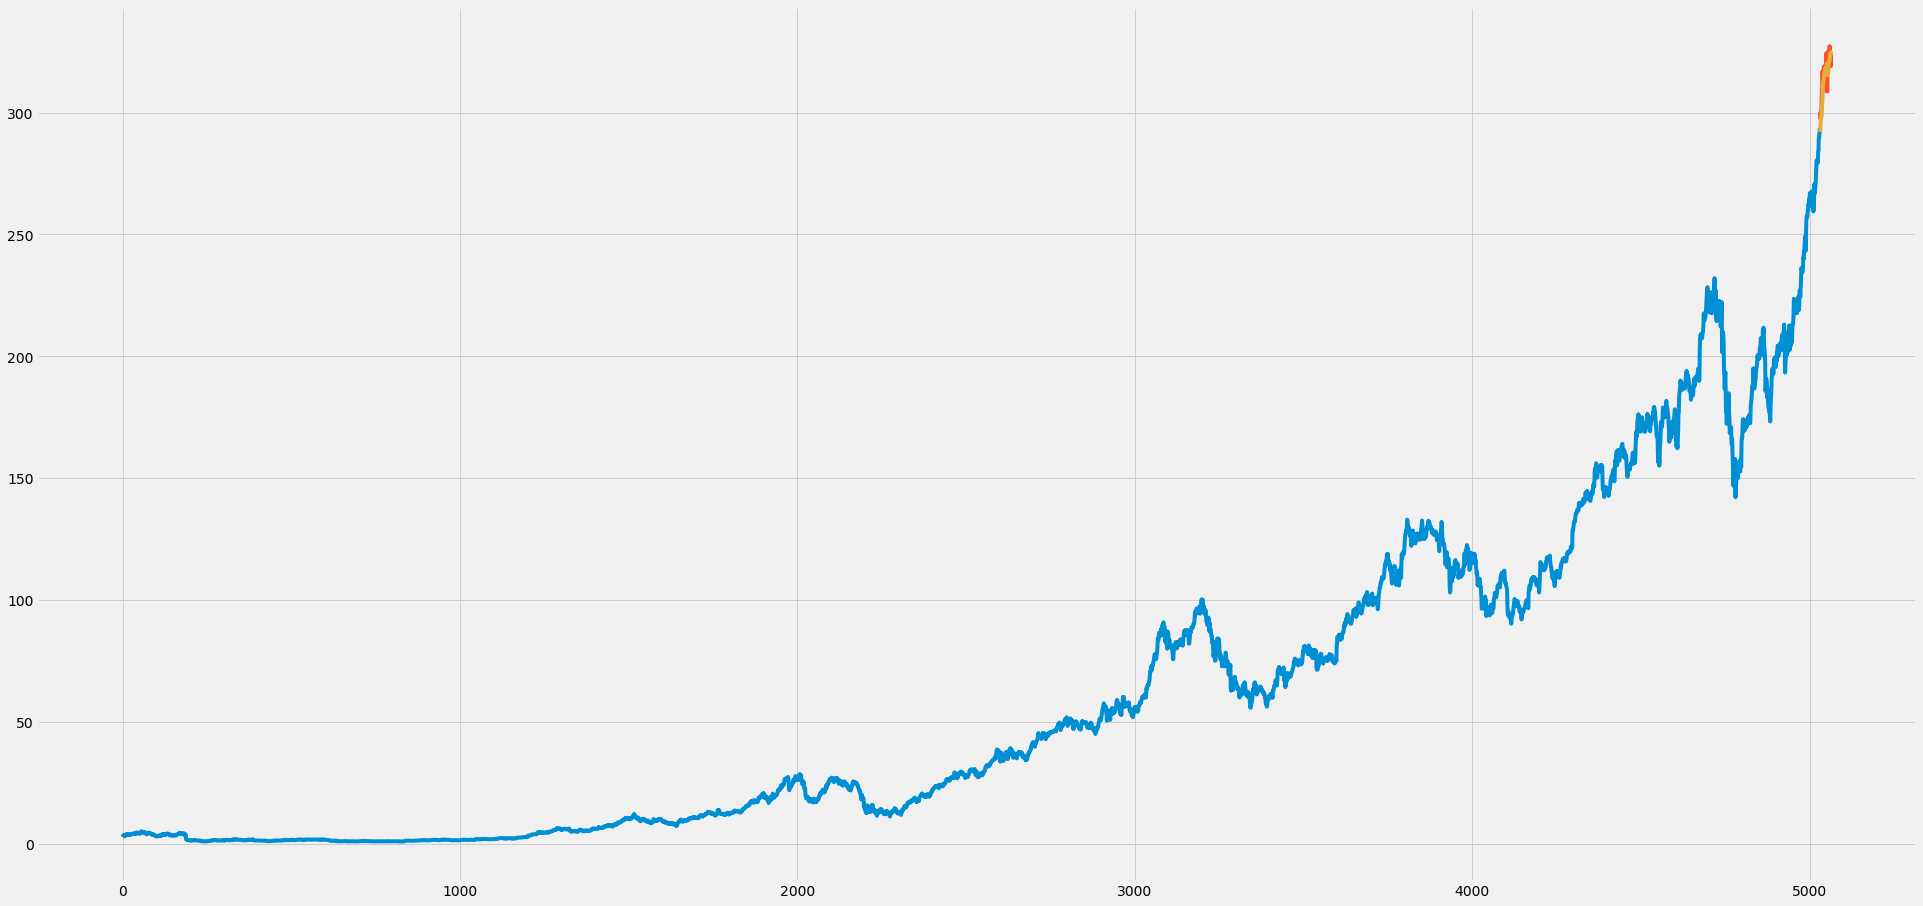

In [ ]:
train_data = new_dataset[:5031]
valid_data = new_dataset[5031:]
valid_data['Predictions'] = predicted_closing_price
plt.figure(figsize=(30,15))
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

In [ ]:
df = valid_data
fig = px.line(df, y = "Close")
fig.add_scatter(y = df["Predictions"], mode='lines')
fig.show()